<a href="https://colab.research.google.com/github/AndresCar13/Planta-Enferma-IA/blob/main/Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Montar el drive y librerías

In [22]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow
!pip install scikit-learn matplotlib

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

# Ruta a la carpeta del dataset
base_dir = '/content/drive/My Drive/Data/'

# Cargar el archivo CSV
csv_path = os.path.join(base_dir, 'train.csv')
data = pd.read_csv(csv_path)

# Cargar el archivo JSON
json_path = os.path.join(base_dir, 'label_num_to_disease_map.json')
with open(json_path, 'r') as f:
    label_map = json.load(f)


# Mostrar las primeras filas del DataFrame
print(data.head())

# Mostrar la distribución de las clases
print(data['label'].value_counts())

# Mostrar el contenido del archivo JSON
print(label_map)

img_dir = os.path.join(base_dir, 'train_images/')

# Lista para almacenar las imágenes que existen
existing_images = []
for i in range(len(data)):
    img_path = os.path.join(img_dir, data.iloc[i]['image_id'])
    if os.path.exists(img_path):
        existing_images.append((img_path, data.iloc[i]['label']))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64
{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


# Definir un modelo CNN

In [23]:
# Preparar los generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=data,
    directory=img_dir,
    x_col='image_id',
    y_col='label',
    subset='training',
    batch_size=32,
    shuffle=True,
    class_mode='raw',
    target_size=(128, 128)
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=data,
    directory=img_dir,
    x_col='image_id',
    y_col='label',
    subset='validation',
    batch_size=32,
    shuffle=True,
    class_mode='raw',
    target_size=(128, 128)
)

# Definir el modelo de CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 clases (4 enfermedades + 1 sano)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()


Found 14351 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3459 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 3587 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3459 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 128)      

# Entrenar el modelo

In [24]:
# Entrenar el modelo
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    epochs=epochs
)

# Para guardar el modelo
#model.save('/content/drive/My Drive/Data/cassava_model.h5')


Epoch 1/20
448/448 [==============================] - 3911s 9s/step - loss: 1.1246 - accuracy: 0.6192 - val_loss: 1.0005 - val_accuracy: 0.6364
Epoch 2/20
448/448 [==============================] - 799s 2s/step - loss: 1.0072 - accuracy: 0.6397 - val_loss: 0.9629 - val_accuracy: 0.6434
Epoch 3/20
448/448 [==============================] - 846s 2s/step - loss: 0.9476 - accuracy: 0.6537 - val_loss: 0.9044 - val_accuracy: 0.6666
Epoch 4/20
448/448 [==============================] - 866s 2s/step - loss: 0.8990 - accuracy: 0.6688 - val_loss: 0.8845 - val_accuracy: 0.6797
Epoch 5/20
448/448 [==============================] - 878s 2s/step - loss: 0.8744 - accuracy: 0.6711 - val_loss: 0.9336 - val_accuracy: 0.6663
Epoch 6/20
448/448 [==============================] - 842s 2s/step - loss: 0.8540 - accuracy: 0.6790 - val_loss: 0.8619 - val_accuracy: 0.6749
Epoch 7/20
448/448 [==============================] - 857s 2s/step - loss: 0.8215 - accuracy: 0.6896 - val_loss: 0.8021 - val_accuracy: 0.690

# Evaluar el modelo

In [29]:
# Evaluar el modelo
validation_generator.reset()
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.n // validation_generator.batch_size)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


112/112 [==============================] - 83s 737ms/step - loss: 0.7354 - accuracy: 0.7313
Validation Loss: 0.7353628277778625
Validation Accuracy: 0.7313057780265808


# Matriz de confusión

112/112 [==============================] - 89s 772ms/step


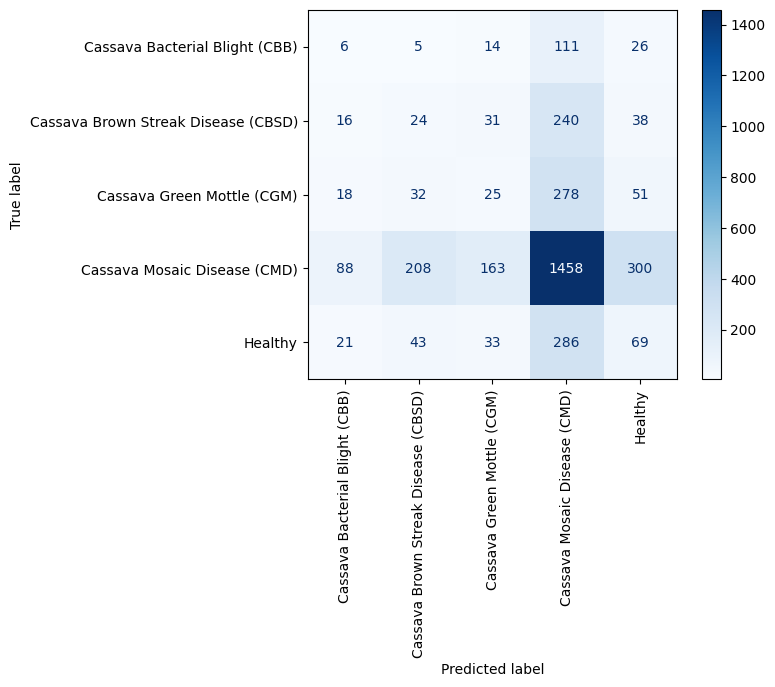

In [31]:
# Obtener las predicciones del modelo
y_pred_prob = model.predict(validation_generator, steps=validation_generator.n // validation_generator.batch_size)
y_pred = np.argmax(y_pred_prob, axis=-1)

# Obtener las etiquetas verdaderas
# Usar una lista para recolectar todas las etiquetas verdaderas del generador de validación
y_true = []

for i in range(len(validation_generator)):
    _, labels = validation_generator[i]
    y_true.extend(labels)

# Convertir y_true a un array de numpy
y_true = np.array(y_true, dtype=int)

# Asegurarse de que las longitudes de y_true y y_pred coincidan
min_length = min(len(y_true), len(y_pred))
y_true = y_true[:min_length]
y_pred = y_pred[:min_length]

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=list(label_map.values()))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)  # Rotar etiquetas del eje x 90 grados
plt.show()

# Procesar imágen final

In [37]:
# Importar las Librerías Necesarias
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Función para Cargar y Preprocesar la Imagen
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expandir dimensiones para que se ajuste al input del modelo
    img_array /= 255.0  # Normalizar la imagen
    return img_array

# Función para Hacer la Predicción
def predict_image_class(model, img_array, label_map):
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = label_map[str(predicted_class[0])]
    return predicted_label, predictions[0]

# Función para Visualizar la Imagen y la Predicción
def plot_image_with_prediction(img_path, predicted_label, predictions, label_map):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}\n' + "\n".join([f'{label_map[str(i)]}: {pred:.2f}' for i, pred in enumerate(predictions)]))
    plt.axis('off')
    plt.show()

# Ingrese su imágen:

1/1 [==============================] - 0s 59ms/step


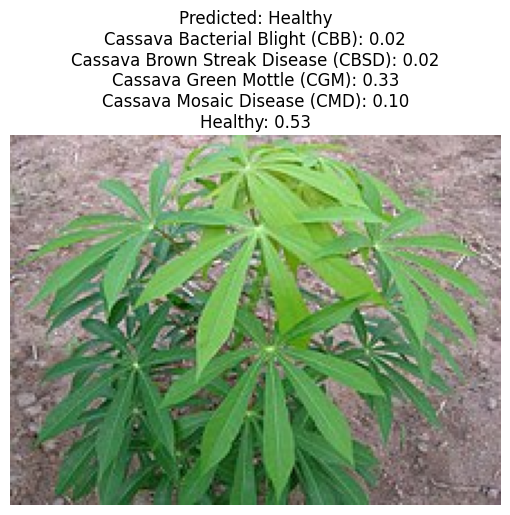

In [39]:
# Ruta a la imagen que quieres predecir
img_path = '/content/drive/MyDrive/Proyecto final/220px-Iwata_kenichi_cassava.jpg'

# Cargar y preprocesar la imagen
img_array = load_and_preprocess_image(img_path)

# Hacer la predicción
predicted_label, predictions = predict_image_class(model, img_array, label_map)

# Visualizar la imagen y la predicción
plot_image_with_prediction(img_path, predicted_label, predictions, label_map)

1/1 [==============================] - 0s 36ms/step


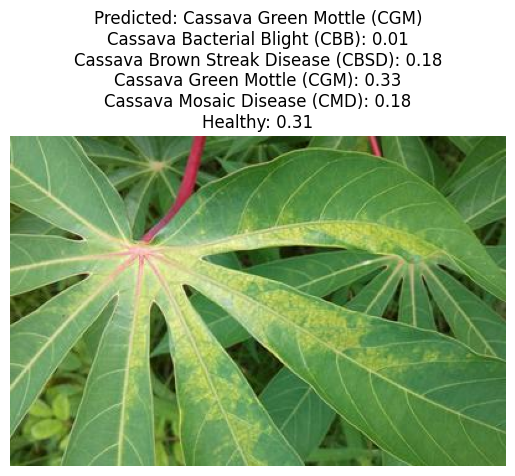

In [40]:
# Ruta a la imagen que quieres predecir
img_path = '/content/drive/MyDrive/Proyecto final/enferma.jpg'

# Cargar y preprocesar la imagen
img_array = load_and_preprocess_image(img_path)

# Hacer la predicción
predicted_label, predictions = predict_image_class(model, img_array, label_map)

# Visualizar la imagen y la predicción
plot_image_with_prediction(img_path, predicted_label, predictions, label_map)